In [1]:
import os
import pickle
import numpy as np
import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

# load `SpenderQ` models

In [3]:
niter = 3 

models = [] 
for imodel in range(5): 
    # load model
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.edr.hiz.sa1p5sb1p5.i%i.%i.pt' % (niter, imodel))
    models.append(_models[0])

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


## load a batch

In [4]:
ibatch = 0
with open('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

## `SpenderQ` reconstructions

In [5]:
wave_obs = np.array(models[0].wave_obs)
w_recon = np.array(models[0].wave_rest) # reconstruciton rest-frame wavelength 

recons = [] 
for imodel in range(5): 
    frecon = '/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % (niter, imodel, ibatch)
    flatent = '/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.latents.npy' % (niter, imodel, ibatch)
    if os.path.isfile(frecon): 
        recon = np.load(frecon)
    else: 
        with torch.no_grad():
            models[imodel].eval()

            s = models[imodel].encode(spec)
            recon = np.array(models[imodel].decode(s))
            
        np.save(flatent, s)
        np.save(frecon, recon)
    recons.append(recon)
    
recons = np.array(recons)    

# some demos of `SpenderQ`

In [22]:
np.sum((np.array(z) > 3.) & (np.array(norm) > 2.))

np.int64(13)

[388 100 601 146]


/tmp/ipykernel_2436576/1717292279.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


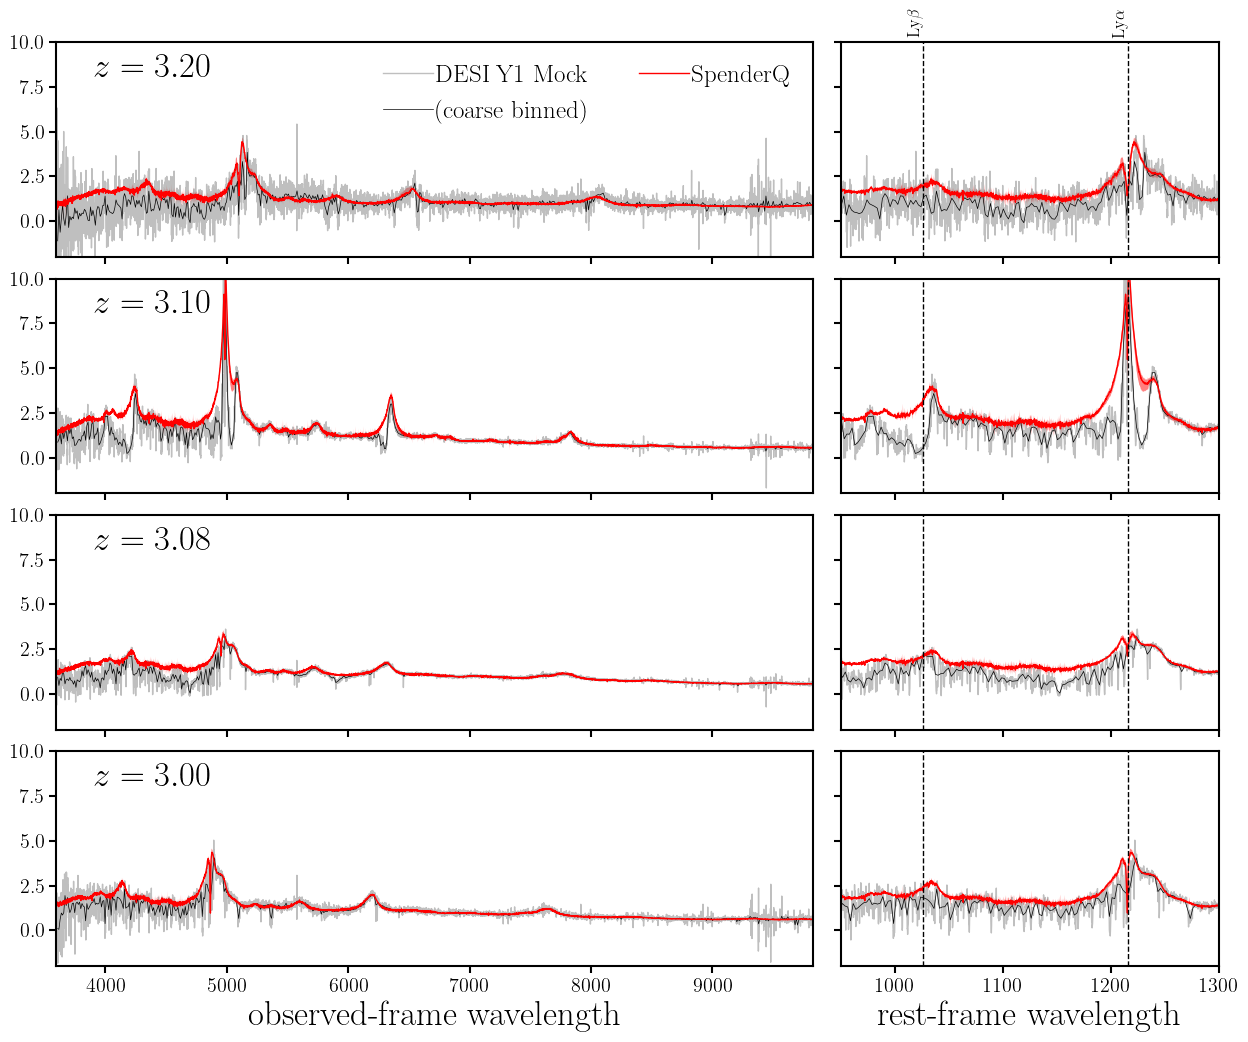

In [23]:
# select high-z and bright (high normalization) quasars
highzs = np.random.choice(np.arange(len(z))[(z > 3.) & (norm > 2.)], size=4, replace=False)
print(highzs)

fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(len(highzs), 2, width_ratios=[2, 1]) 

# observed-frame full spectra
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii])
    
    # full spectra
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='DESI Y1 Mock')
    
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    # spenderq recon
    sub.fill_between(models[0].wave_rest * (1+z[igal]), 
                     np.min(recons[:,igal,:], axis=0), 
                     np.max(recons[:,igal,:], axis=0), color='r', edgecolor='None', alpha=0.5)
    sub.plot(models[0].wave_rest * (1+z[igal]), np.mean(recons[:,igal,:], axis=0), color='r', lw=1, label=r'SpenderQ')    
    
    # redshift
    sub.text(0.05, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', ncol=2, fontsize=18, handletextpad=0.1)
    sub.set_ylim(-2, 10.)
sub.set_xlabel("observed-frame wavelength", fontsize=25)

# zoom in rest-frame LyA region 
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii+1])    
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='DESI')
    #sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=0.5)

    # spenderq
    sub.fill_between(models[0].wave_rest, 
                 np.min(recons[:,igal,:], axis=0), 
                 np.max(recons[:,igal,:], axis=0), color='r', edgecolor='None', alpha=0.5)
    sub.plot(models[0].wave_rest, np.mean(recons[:,igal,:], axis=0), color='r', lw=1, label=r'SpenderQ')    
    

    sub.axvline(1026, color='k', linewidth=1, linestyle='--')
    sub.axvline(1216, color='k', linewidth=1, linestyle='--')
    if ii == 0:     
        sub.text(1026, 11.8, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
        sub.text(1216, 11.8, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

    sub.set_xlim(950., 1300.)
    if ii < len(highzs)-1: sub.set_xticklabels([])
    sub.set_ylim(-2, 10.)
    sub.set_yticklabels([])
    
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.savefig('spenderq_edr_demo.pdf', bbox_inches='tight')

## demo video

In [124]:
def plot_demo(igal, spec, w, z, recon, plot_recon=False): 
    fig = plt.figure(figsize=(12,4))
    sub = fig.add_subplot(111)
    # spectrum
    sub.plot(wave_obs, np.array(spec)[igal], c='k', alpha=0.5, lw=1)

    # mask out w = 0
    y0, y1 = sub.get_ylim()
    i0, i1 = (np.arange(w.shape[1])[np.array(w[igal]) == 0])[0], (np.arange(w.shape[1])[np.array(w[igal]) == 0])[0]
    while i0 < w.shape[1]: 
        for i in range(w.shape[1]-i0): 
            if w[igal][i0+i] != 0: 
                i1 = i0+i-1
                break    
            if i0+i == w.shape[1]: 
                break

        sub.fill_between([wave_obs[i0], wave_obs[i1]], [y0, y0], [y1, y1], 
                         color='gray', edgecolor='None', zorder=10, alpha=0.25)
        try: 
            i0 = (np.arange(w.shape[1])[(np.array(w[igal]) == 0) & (wave_obs > wave_obs[i1])])[0]
        except IndexError: 
            break
    
    if plot_recon: 
        sub.plot(w_recon[::10] * (1 + np.array(z)[igal]), recon[igal][::10], c='r', lw=2)
    sub.text(0.02, 0.95, '$z = %.2f$' % (np.array(z)[igal]), transform=sub.transAxes, ha='left', va='top', fontsize=25)
    sub.text(0.02, 0.80, 'DESI EDR', transform=sub.transAxes, ha='left', va='top', fontsize=20, color='gray')
    sub.text(0.02, 0.70, 'SpenderQ', transform=sub.transAxes, ha='left', va='top', fontsize=20, color='r')
    sub.set_xlabel(r'observed wavelength [\r{A}]', fontsize=25)
    sub.set_xlim(3.6e3, 9.8e3)
    sub.set_ylabel('flux', fontsize=25)
    sub.set_ylim(y0, y1)
    plt.show()
    return fig

In [129]:
igal = 100#146

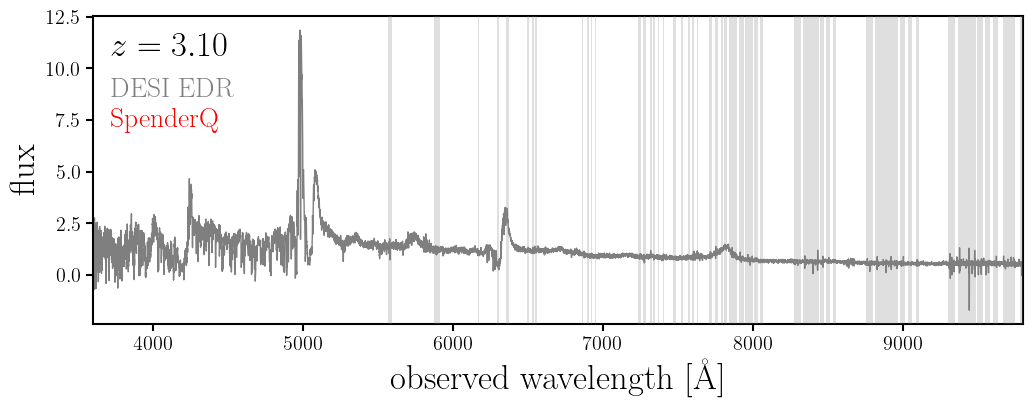

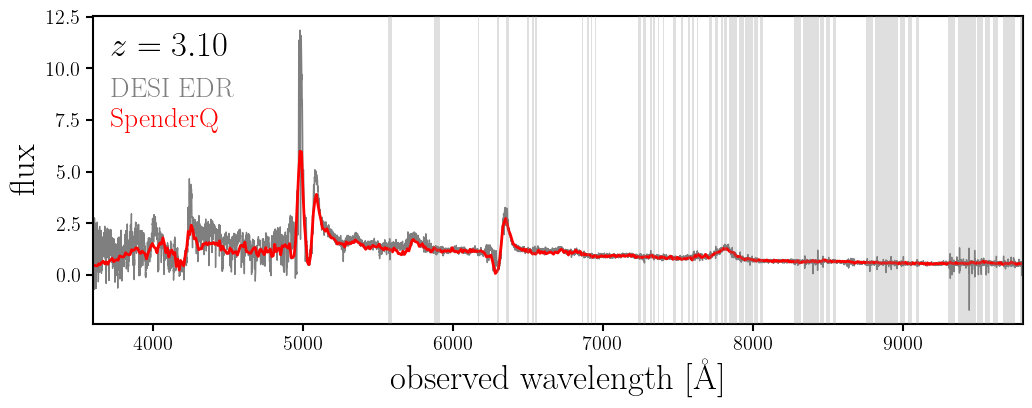

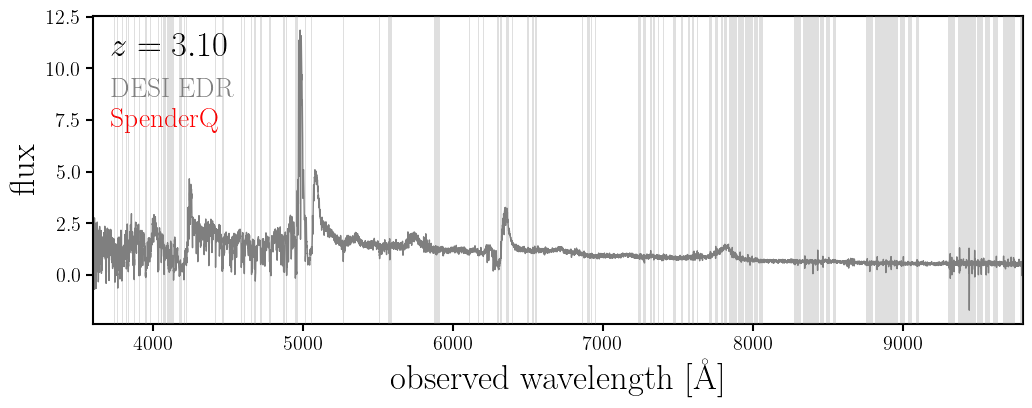

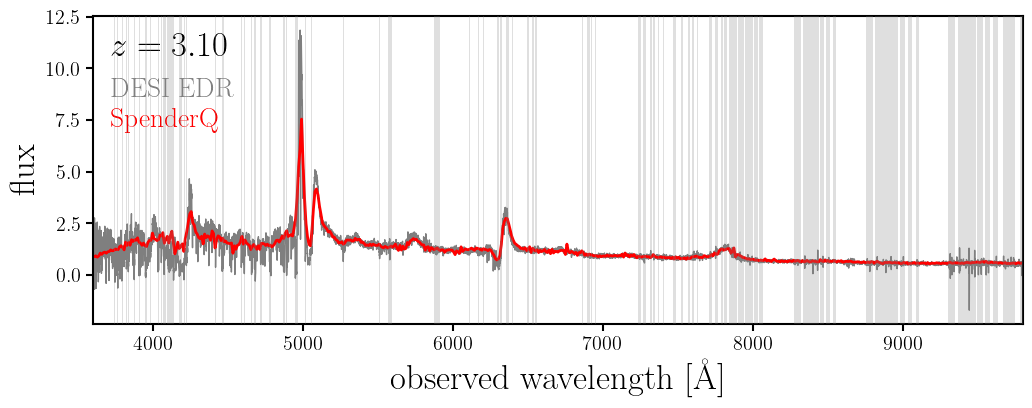

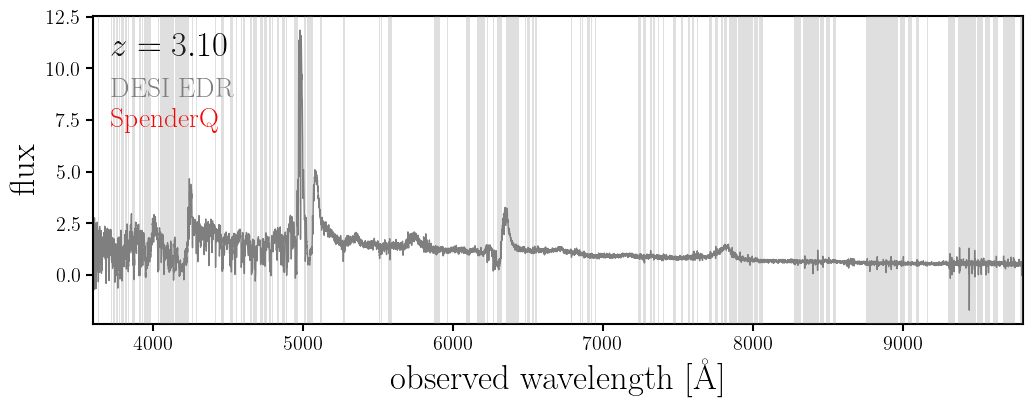

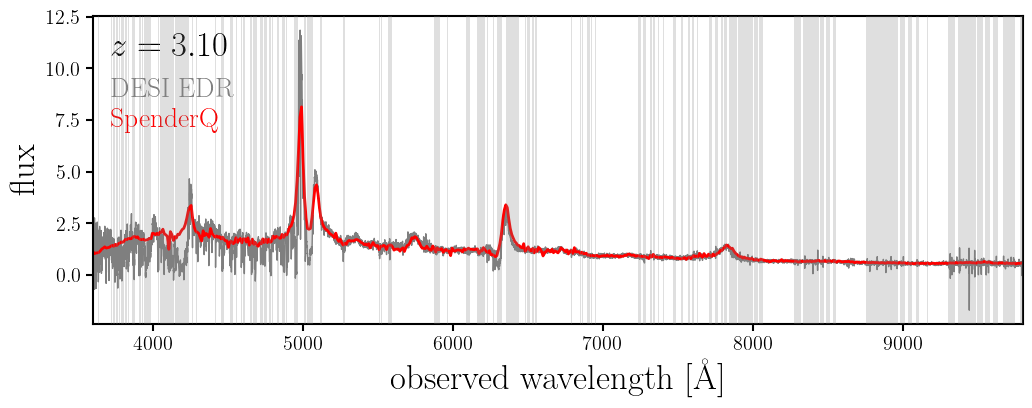

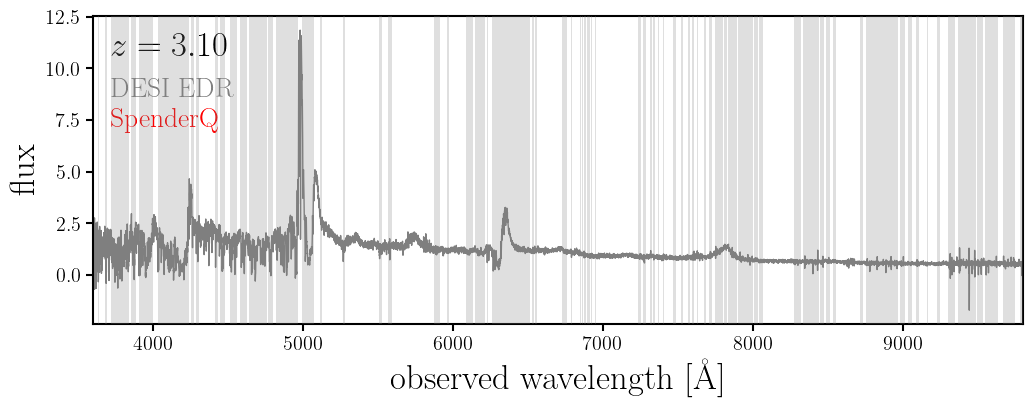

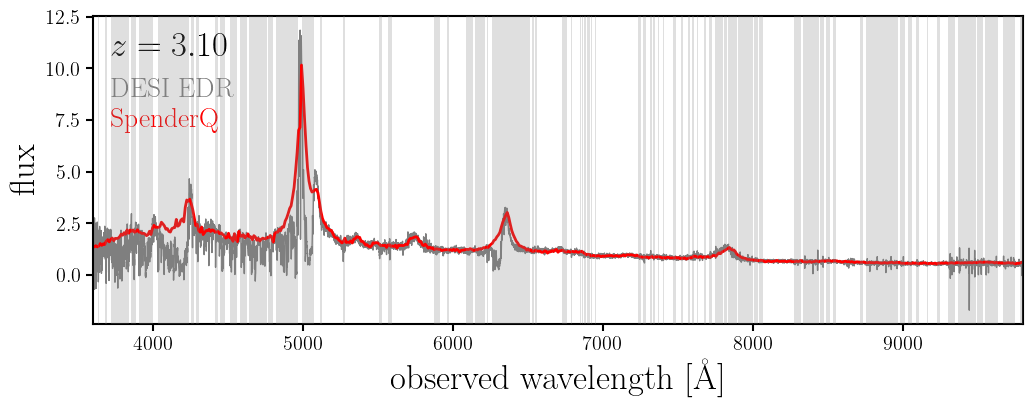

In [130]:
with open('/tigress/chhahn/spender_qso/train/DESI.edr.qso_highz_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
recon = np.load('/tigress/chhahn/spender_qso/train/DESI.edr.qso_highz_0.recons.npy')

ifig = 0 

fig = plot_demo(igal, spec, w, z, recon, plot_recon=False)
fig.savefig('demo%i.png' % ifig, bbox_inches='tight')
ifig +=1 

fig = plot_demo(igal, spec, w, z, recon, plot_recon=True)
fig.savefig('demo%i.png' % ifig, bbox_inches='tight')
ifig +=1 

for niter in range(3): 
    with open('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)

    recon = np.load('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.recons.npy' % (niter, ibatch))

    fig = plot_demo(igal, spec, w, z, recon, plot_recon=False)
    fig.savefig('demo%i.png' % ifig, bbox_inches='tight')
    ifig +=1 
    
    fig = plot_demo(igal, spec, w, z, recon, plot_recon=True)
    fig.savefig('demo%i.png' % ifig, bbox_inches='tight')
    ifig +=1 